In [1]:
import math
import numpy as np
import scipy as sp
from scipy.linalg import eig
from numpy import sin, cos, abs, exp, sqrt, arccos, pi

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

C:\Users\alber\AppData\Local\Temp\ipykernel_25840\1148331406.py:14: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
gamma = 5e-2 # 5e-2 # Total loss rate 
J = 1.0 # Tunneling
N = 500 # Number of cavities
F_value = 0.75/sqrt(2) # Pump
Delta_n = 6 # Distance
U_list = np.array([0.0, 0.1, 0.4, 0.8])*J**3/F_value**2 # Kerr non-linearity

In [3]:
def f_RK4(Delta, U, gamma, J, F, a):

    # Open boundary conditions
    a_l = np.concatenate((np.zeros(1), a[:-1]))
    a_r = np.concatenate((a[1:], np.zeros(1)))

    # Periodic boundary conditions
    #a_l = np.concatenate((np.ones(1)*a[-1], a[:-1]))
    #a_r = np.concatenate((a[1:], np.ones(1)*a[0]))

    y = -1.0j * (
        -Delta*a + U*abs(a)**2*a -1.0j*gamma*a - J*a_l - J*a_r + F
    )
    
    return y

N_t = 1e3 # Number of time steps
t_f = 1e2 # Final time
t = np.linspace(0, t_f, int(N_t))
Delta_t = t[1] - t[0]

### 4th order RK time evolution

===> index = 0
Maximum intensity at \Delta = 2.0
50


===> index = 1


C:\Users\alber\AppData\Local\Temp\ipykernel_25840\3234239857.py:66: RuntimeWarning: divide by zero encountered in true_divide
  D = 1/sqrt(4*J**2-Delta_list_analytic**2)


Maximum intensity at \Delta = -1.5918367346938775
5


===> index = 2
Maximum intensity at \Delta = -1.0204081632653061
12


===> index = 3
Maximum intensity at \Delta = -0.44897959183673475
19




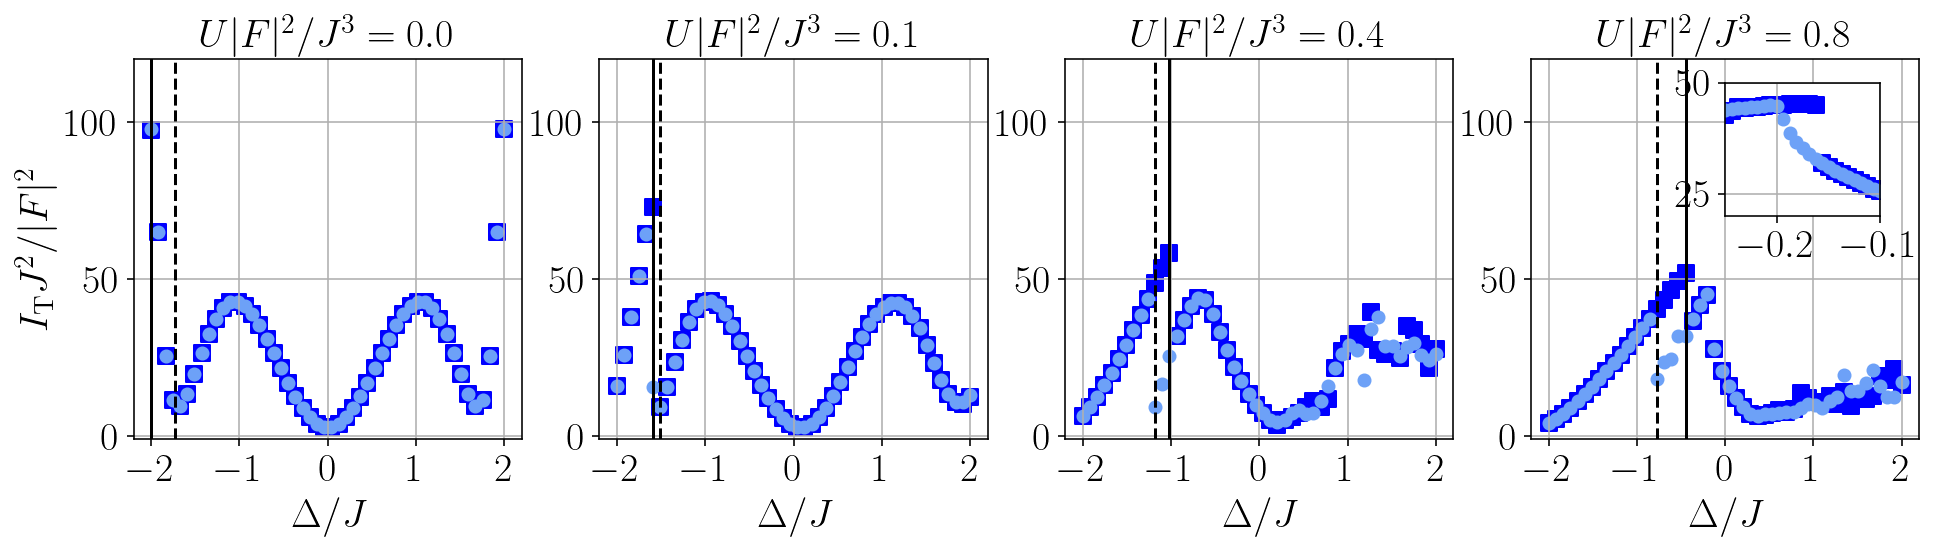

In [4]:
plt.rcParams["figure.figsize"] = [16, 3.5]
fig, ax = plt.subplots(1, 4)
fs = 20
lw = 2
marker_size = 60

for i_U, U in enumerate(U_list):

    print('===> index = {:}'.format(i_U))

    ax[i_U].grid()

    Delta_list = np.concatenate((np.linspace(-2, 2, 50), np.linspace(2, -2, 50)))

    # Cavity-laser coupling
    ll_list = np.zeros(len(Delta_list), dtype=np.float64)
    a_list = np.zeros(len(Delta_list), dtype=np.float64)
    a_total_list = np.zeros(len(Delta_list), dtype=np.float64)

    n1 = 249
    F = np.zeros(N, dtype=np.complex128)
    n2 = n1 + Delta_n
    F[int(n1)] = F_value
    F[int(n2)] = F_value

    # Cavity fields
    a = np.zeros((N, int(N_t)), dtype=np.complex128)

    for i_Delta, Delta in enumerate(Delta_list):

        #print('Delta = {:}'.format(Delta_list[i_Delta]))

        for i_t in range(len(t)-1):

            k1 = f_RK4(Delta, U, gamma, J, F, a[:, i_t])
            k2 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k1*Delta_t/2)
            k3 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k2*Delta_t/2)
            k4 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k3*Delta_t)

            a[:, i_t+1] = a[:, i_t] + (k1 + 2*k2 + 2*k3 + k4)*Delta_t/6

        a[:, 0] = a[:, -1]

        # We define a parameter characterizing the light localization
        ll_list[i_Delta] = np.sum(np.abs(a[249+1:249+Delta_n, -1])**2) / np.sum(np.abs(a[:, -1])**2) 
        a_list [i_Delta] = np.sum(np.abs(a[249+1:249+Delta_n, -1])**2) 
        a_total_list[i_Delta] = np.sum(np.abs(a[:, -1])**2) 

    print('Maximum intensity at \Delta = {:}'.format(Delta_list[np.argmax(np.array(a_total_list))]))
    print(np.argmax(np.array(a_total_list)))
    print('\n')

    ########
    # PLOT #
    ########    

    Delta_list = np.concatenate((np.linspace(-2, 2, 50), np.linspace(2, -2, 50)))
    ax[i_U].scatter(Delta_list[:int(len(Delta_list)/2)], a_total_list[:int(len(Delta_list)/2)]*J**2/abs(F_value)**2, color='blue', marker='s', s=marker_size)
    ax[i_U].scatter(Delta_list[int(len(Delta_list)/2):], a_total_list[int(len(Delta_list)/2):]*J**2/abs(F_value)**2, color=[0.427, 0.631, 0.969])

    #ax[i_U].plot(Delta_list_linear, a_total_list_linear*J/abs(F_value)**2, '--k')

    # Linear case: analytic solution
    Delta_list_analytic = np.linspace(-2, 2, 1000)
    k0 = arccos(-Delta_list_analytic/(2*J))
    D = 1/sqrt(4*J**2-Delta_list_analytic**2)
    d = Delta_n
    integral = 2*np.abs(F_value)**2*D/gamma*(1+cos(k0*d)*exp(-gamma*D*d))
    #ax[i_U].plot(Delta_list_analytic, 2*integral, '-k', linewidth=lw)

    if i_U > 0:
        ax[i_U].plot([Delta_list[np.argmax(np.array(a_total_list))], Delta_list[np.argmax(np.array(a_total_list))]], [-1, 120], '-k')
    else:
        ax[i_U].plot([-2*cos((2*0)*pi/Delta_n), -2*cos((2*0)*pi/Delta_n)], [-1, 120], '-k')

    #ax[i_U].set_ylim([0.0, 1.5])
    ax[i_U].set_xlabel(r'$\Delta/J$', fontsize=fs)
    #ax[i_U].set_ylabel(r'$I_{\rm T} J/|F|^2$', fontsize=fs)
    ax[i_U].tick_params(axis='both', labelsize=fs)

    ax[i_U].set_xticks(np.arange(-2, 3, 1))
    ax[i_U].set_ylim(-1, 120)
    ax[i_U].set_title(r'$U|F|^2/J^3={:.1f}$'.format(U*abs(F_value)**2/J**3), fontsize=fs)

ax[0].set_ylabel(r'$I_{\rm T} J^2/|F|^2$', fontsize=fs)

ax[0].plot([-2*cos((2*0+1)*pi/Delta_n), -2*cos((2*0+1)*pi/Delta_n)], [-1, 120], '--k')
ax[1].plot([Delta_list[len(Delta_list) - 7], Delta_list[len(Delta_list) - 7]], [-1, 120], '--k')
ax[2].plot([Delta_list[len(Delta_list) - 11], Delta_list[len(Delta_list) - 11]], [-1, 120], '--k')
ax[3].plot([Delta_list[len(Delta_list) - 16], Delta_list[len(Delta_list) - 16]], [-1, 120], '--k')



######################
# CODE FOR THE INSET #
######################

gamma = 5e-2 # 5e-2 # Total loss rate 5e-2
J = 1.0 # Inter-cavity coupling
N = 500 # Number of cavities
F_value = 0.75/sqrt(2)
#Delta_list = np.linspace(-2, 2, 50)
Delta_list_inset = np.concatenate((np.linspace(-0.25, -0.1, 25), np.linspace(-0.1, -0.25, 25)))
Delta_n = 6

N_t = 1e3 # Number of time steps
t_f = 1e2 # Final time; units of 1/gamma_T
t = np.linspace(0, t_f, int(N_t))
Delta_t = t[1] - t[0]

# Cavity-laser coupling
ll_list_inset = np.zeros(len(Delta_list_inset), dtype=np.float64)
a_list_inset = np.zeros(len(Delta_list_inset), dtype=np.float64)
a_total_list_inset = np.zeros(len(Delta_list_inset), dtype=np.float64)

n1 = 249
F = np.zeros(N, dtype=np.complex128)
n2 = n1 + Delta_n
F[int(n1)] = F_value
F[int(n2)] = F_value

# Cavity fields
a = np.zeros((N, int(N_t)), dtype=np.complex128)

for i_Delta, Delta in enumerate(Delta_list_inset):

    #print('Delta = {:}'.format(Delta_list_inset[i_Delta]))

    for i_t in range(len(t)-1):

        k1 = f_RK4(Delta, U, gamma, J, F, a[:, i_t])
        k2 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k1*Delta_t/2)
        k3 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k2*Delta_t/2)
        k4 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k3*Delta_t)

        a[:, i_t+1] = a[:, i_t] + (k1 + 2*k2 + 2*k3 + k4)*Delta_t/6

    a[:, 0] = a[:, -1]

    # We define a parameter characterizing the light localization
    ll_list_inset[i_Delta] = np.sum(np.abs(a[249+1:249+Delta_n, -1])**2) / np.sum(np.abs(a[:, -1])**2) 
    a_list_inset[i_Delta] = np.sum(np.abs(a[249+1:249+Delta_n, -1])**2) 
    a_total_list_inset[i_Delta] = np.sum(np.abs(a[:, -1])**2)     

#################################################################################


# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0, 0, 1, 1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax[i_U], [0.5, 0.5875, 0.4, 0.35])
ax2.set_axes_locator(ip)

ax2.scatter(Delta_list_inset[:int(len(Delta_list_inset)/2)], a_total_list_inset[:int(len(Delta_list_inset)/2)]*J/abs(F_value)**2, color='blue', marker='s', s=marker_size)
ax2.scatter(Delta_list_inset[int(len(Delta_list_inset)/2):], a_total_list_inset[int(len(Delta_list_inset)/2):]*J/abs(F_value)**2, color=[0.427, 0.631, 0.969])

ax2.set_xlim(-0.25, -0.1)
ax2.set_ylim(20, 50)

ax2.grid()
ax2.tick_params(axis='both', labelsize=fs)